In [1]:
"""
proprietà Istituto di Analisi dei Sistemi ed Informatica "Antonio
Ruberti" del Consiglio Nazionale delle Ricerche

10/12/2023   versione v. 1.0

Autori:
Diego Maria Pinto
Marco Boresta
Giuseppe Stecca
Giovanni Felici
"""
import os
import movingpandas as mpd
mpd.show_versions()
import warnings
warnings.simplefilter("ignore")
import pandas as pd
import movingpandas as mpd
import matplotlib.pyplot as plt
from IPython.display import display
from datetime import timedelta
from holoviews import opts
import numpy as np

plot_defaults = {'linewidth':5, 'capstyle':'round', 'figsize':(9,3), 'legend':True}
opts.defaults(opts.Overlay(active_tools=['wheel_zoom'], frame_width=500, frame_height=400))

/home/dmp/anaconda3/envs/arpa_venv/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 13.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(



MovingPandas 0.17.2

SYSTEM INFO
-----------
python     : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
executable : /home/dmp/anaconda3/envs/arpa_venv/bin/python
machine    : Linux-5.15.90.1-microsoft-standard-WSL2-x86_64-with-glibc2.31

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 3.7.3
GDAL data dir: /home/dmp/anaconda3/envs/arpa_venv/share/gdal
PROJ       : 9.3.0
PROJ data dir: /home/dmp/anaconda3/envs/arpa_venv/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.14.0
pandas     : 2.1.2
fiona      : 1.9.5
numpy      : 1.26.0
shapely    : 2.0.2
rtree      : 1.1.0
pyproj     : 3.6.1
matplotlib : 3.8.1
mapclassify: None
geopy      : 2.4.0
holoviews  : 1.18.1
hvplot     : 0.9.0
geoviews   : 1.11.0
stonesoup  : None


In [2]:
def load_data(filepath, filename):
    file = filepath + filename
    data = pd.read_csv(file)
    return data

cwd = os.getcwd()
data_path = cwd + '/Data/'
file_name = 'preprocessed_data_22_23.xlsx'

df = pd.read_excel(data_path + file_name)

In [3]:
df.shape

(9102, 14)

# prova per verificare se le metriche si perfezionano rimuovendo i record dove GPS_num_sats è minore di un certo numero

In [4]:
len(df[df['GPS_num_sats'] < 3])

482

In [5]:
df = df[df['GPS_num_sats'] >= 3]
len(df)

8620

In [6]:
df.head(100)

,Unnamed: 0,index,file_source,node_sn,timestamp,GPS_lat,GPS_lon,GPS_alt,GPS_speed,GPS_num_sats,temperature,batt_level,date,time
0,0,546,old_2022,1,2022-03-28 17:12:50,45.013988,7.56788,275,0.0,4,25.8305,NaN,2022-03-28,17:12:50
1,1,547,old_2022,1,2022-03-28 17:25:50,45.013870,7.56798,289,0.0,4,26.1349,NaN,2022-03-28,17:25:50
2,2,551,old_2022,1,2022-03-28 19:23:23,45.012569,7.56539,111,0.0,3,21.1734,NaN,2022-03-28,19:23:23
3,3,862,old_2022,1,2022-04-01 09:08:12,45.046070,7.64608,126,0.0,4,22.0813,NaN,2022-04-01,09:08:12
4,4,872,old_2022,1,2022-04-01 10:04:18,45.044682,7.64688,284,0.0,5,22.3217,NaN,2022-04-01,10:04:18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,1842,old_2022,1,2022-04-05 10:05:40,45.044800,7.64619,178,0.0,4,19.2561,NaN,2022-04-05,10:05:40
96,96,1848,old_2022,1,2022-04-05 11:06:36,45.044609,7.64625,280,0.0,5,18.8556,NaN,2022-04-05,11:06:36
97,97,1855,old_2022,1,2022-04-05 12:06:16,45.044559,7.64687,249,2.4,5,17.9343,NaN,2022-04-05,12:06:16
98,98,1862,old_2022,1,2022-04-05 13:06:04,45.044762,7.64679,346,0.0,4,18.8022,NaN,2022-04-05,13:06:04


In [7]:
class bbox:
    def __init__(self, location_name, north, west, south, east):
        self.location_name = location_name
        self.north = north
        self.west = west
        self.south = south
        self.east = east

    def is_in_bbox(self, lat, long):
        if ((lat > self.south) and (lat < self.north) and (long > self.west) and (long < self.east)):
            return True
        else:
            return False

def check_in_bbox_list(bbox_list, location_tuple):
    location = 'Break-Location'
    for bbox in bbox_list:
        if bbox.is_in_bbox(location_tuple[0], location_tuple[1]) == True:
            location = bbox.location_name
    return location

In [8]:
trucks_ids = list(df.node_sn.unique())
trucks_ids.sort()
print('All different truck IDs are: ' + str(trucks_ids))

main_traj_collection = mpd.TrajectoryCollection(df, 'node_sn', t='timestamp', x='GPS_lon', y='GPS_lat')
hvplot_defaults = {'tiles': 'OSM', 'frame_height': 550, 'frame_width': 550, 'line_width': 7.0}

All different truck IDs are: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 19, 20, 24, 25, 26, 27]


In [9]:
df.columns

Index(['Unnamed: 0', 'index', 'file_source', 'node_sn', 'timestamp', 'GPS_lat',
       'GPS_lon', 'GPS_alt', 'GPS_speed', 'GPS_num_sats', 'temperature',
       'batt_level', 'date', 'time'],
      dtype='object')

In [10]:
bbox_Gerbole = bbox('Gerbole', 45.00608379933475, 7.494028665630488, 44.9789664976549, 7.541781329617419)
bbox_Samsung = bbox('Samsung', 47.45, 19.12, 47.40, 19.19)
bbox_Mirafiori = bbox('Mirafiori',45.03783123341941, 7.61185459392937,   45.01659162577987, 7.637021253139538)

bbox_Gerbole = bbox('Gerbole', 45.05, 7.30, 44.5, 7.75)
bbox_Samsung = bbox('Samsung', 47.80, 19.0, 47.10, 19.30)
bbox_Mirafiori = bbox('Mirafiori',45.04, 7.58, 45.01, 7.68)

main_bbox_list = [bbox_Gerbole, bbox_Samsung, bbox_Mirafiori]
main_locs_list = ['Gerbole', 'Samsung', 'Mirafiori']

truck ID considered is 2
route sampling interval is 0 days 01:00:56
splitting truck ID 2 data produces 2 main trajectories: 

trajectory 0 began on 2022-04-01 06:23:40 from Mirafiori travelling 777.25 km in 15:06:45 hours, ended on 2022-04-01 21:30:25 at Break-Location
trajectory 1 began on 2022-04-04 16:30:21 from Break-Location travelling 223.1 km in 5:03:16 hours, ended on 2022-04-04 21:33:37 at Samsung


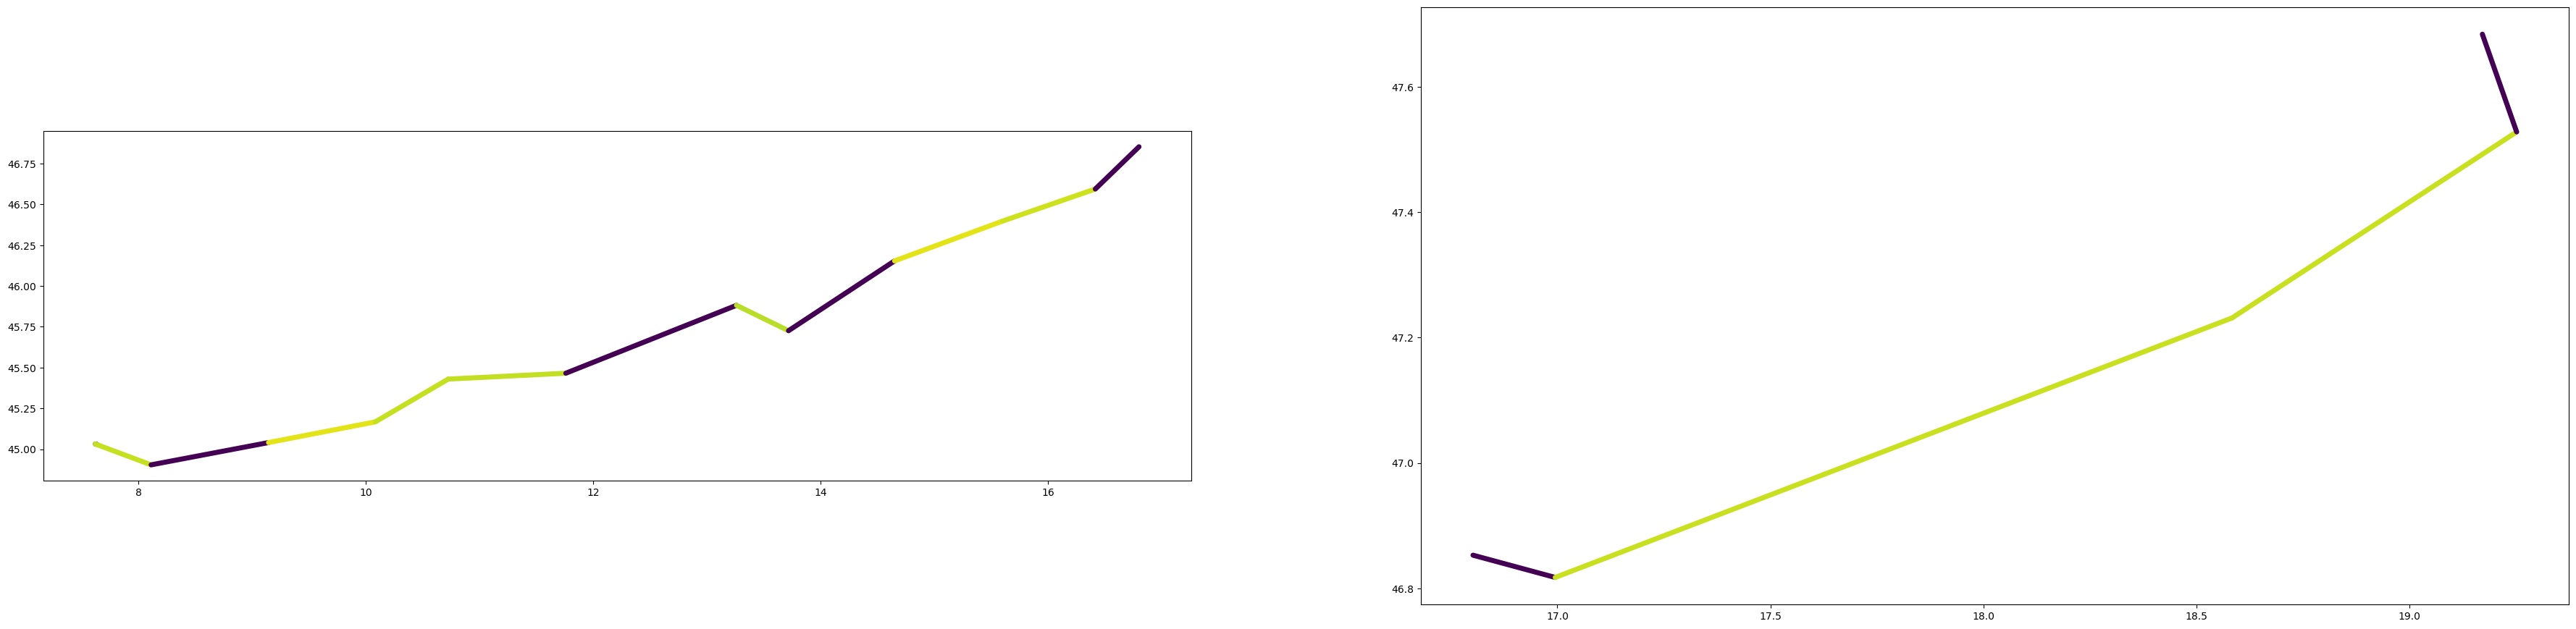

In [11]:
truck_id = 2 #7 #9
print('truck ID considered is '+ str(truck_id))
my_traj = main_traj_collection.get_trajectory(truck_id)
print('route sampling interval is ' + str(my_traj.get_sampling_interval()))
# Split the trajectory where observations stay within max_diameter meters for at least timedelta minutes.
# Discard created trajectories that are shorter than min_length meters long # unit measures are in meters
truck_subcollection_stopsplit = mpd.StopSplitter(my_traj).split(max_diameter=500, min_duration=timedelta(hours=1), min_length=5000) #5km
print('splitting truck ID ' + str(truck_id) + ' data produces ' + str(len(truck_subcollection_stopsplit)) + ' main trajectories: \n')

for i, traj in enumerate(truck_subcollection_stopsplit):
    start_location_latlong = (traj.get_start_location().y, traj.get_start_location().x) # tuple (lat,long)
    start_location = check_in_bbox_list(main_bbox_list, start_location_latlong)
    end_location_latlong   = (traj.get_end_location().y, traj.get_end_location().x) # tuple (lat,long)
    end_location = check_in_bbox_list(main_bbox_list, end_location_latlong)

    print('trajectory', i, 'began on', traj.get_start_time(), 'from', start_location, 'travelling', round(traj.get_length(units='km'),2), 'km in', traj.get_duration(), 'hours, ended on', traj.get_end_time(), 'at',end_location)

if len(truck_subcollection_stopsplit) != 1:
    fig, axes = plt.subplots(nrows=1, ncols=len(truck_subcollection_stopsplit), figsize=(45,25))
    for i, traj in enumerate(truck_subcollection_stopsplit):
        # traj.hvplot(line_width=7.0, tiles='OSM', subplots=True, shared_axes=False)
        traj.plot(ax=axes[i], linewidth=5.0, capstyle='round', column='GPS_speed', vmax=95, tiles  = 'OSM', geo = True)

In [12]:
hvplot_defaults = {'tiles':'CartoLight', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
truck_subcollection_stopsplit.hvplot(**hvplot_defaults)

:Overlay
   .WMTS.I    :WMTS   [Longitude,Latitude]
   .Path.I    :Path   [Longitude,Latitude]
   .Path.II   :Path   [Longitude,Latitude]
   .Points.I  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II :Points   [Longitude,Latitude]   (triangle_angle)

In [13]:
# This function, given a collection of any movingpandas trajectories, a origin & destinantion bbox (as the given class)
# gives a list of trajectory collections from the given origin to the given destination
# this list of similar trajectory can be used then for furhter statistical analysis
def get_trajs_from_to(traj_collection, from_bbox, to_bbox):
    print('##############################################################')
    print('###  Searching for complete set of trajcetories from', from_bbox.location_name, 'to', to_bbox.location_name, '###' )
    print('##############################################################')
    paths_list = [] # the overall collection of paths (from different truck_ids) from "from_bbox" to "to_bbox"
    from_location_name = from_bbox.location_name
    to_location_name = to_bbox.location_name
    paths_by_truck_id = {}
    for truck_id in trucks_ids:
        truck_id_serial_count = 0
        truck_id_paths_list = [] # considering a truck_id, the list of its paths from "from_bbox" to "to_bbox"
        print('#  ' + 'truck ID considered is '+ str(truck_id) +' #')
        my_traj = traj_collection.get_trajectory(truck_id)

        # Split the trajectory where observations stay within max_diameter meters for at least timedelta minutes.
        # Discard created trajectories that are shorter than min_length meters long # unit measures are in meters
        truck_subcollection_stopsplit = mpd.StopSplitter(my_traj).split(max_diameter=500, min_duration=timedelta(hours=1), min_length=5000) #5km
        print('splitting truck ID ' + str(truck_id) + ' data produces ' + str(len(truck_subcollection_stopsplit)) + ' main trajectories: \n')

        for i, traj in enumerate(truck_subcollection_stopsplit):
            truck_id_path_trajs_list = [] # considering a truck_id, and its possible path from "from_bbox" to "to_bbox", this list is made of all the trajectories of this path
            t_0 = traj.get_start_time()
            start_location_latlong = (traj.get_start_location().y, traj.get_start_location().x) # tuple (lat,long)
            start_location = check_in_bbox_list(main_bbox_list, start_location_latlong)
            end_location_latlong   = (traj.get_end_location().y, traj.get_end_location().x) # tuple (lat,long)
            end_location = check_in_bbox_list(main_bbox_list, end_location_latlong)

            if (start_location == from_location_name) and ((end_location == to_location_name) or (end_location == 'Break-Location')): # Samsung to Samsung could happen but not of interest
                truck_id_path_trajs_list.append(traj)
                print('trajectory', i, 'began on', traj.get_start_time(), 'from', start_location, 'travelling', round(traj.get_length(units='km'),2), 'km in', traj.get_duration(), 'hours, ended on', traj.get_end_time(), 'at',end_location)
                if end_location == to_location_name: # i.e. the very fist traj goes from 'from_location_name' to 'to_location_name'
                    truck_id_paths_list.append(truck_id_path_trajs_list)
                    print('Well done !!! trajectories path is added in list !!!')
                    paths_by_truck_id[(truck_id,truck_id_serial_count,from_location_name, to_location_name, t_0)] = truck_id_path_trajs_list
                    truck_id_serial_count += 1
                    continue
                else:
                    j = i + 1
                    while j < len(truck_subcollection_stopsplit):
                        traj = truck_subcollection_stopsplit.trajectories[j]
                        start_location_latlong = (traj.get_start_location().y, traj.get_start_location().x) # tuple (lat,long)
                        start_location = check_in_bbox_list(main_bbox_list, start_location_latlong)
                        end_location_latlong   = (traj.get_end_location().y, traj.get_end_location().x) # tuple (lat,long)
                        end_location = check_in_bbox_list(main_bbox_list, end_location_latlong)
                        if (start_location == 'Break-Location') and ((end_location == to_location_name) or (end_location == 'Break-Location')) and (end_location not in list((set(main_locs_list) - set([to_location_name])))):
                            truck_id_path_trajs_list.append(traj)
                            print('trajectory', j, 'began on', traj.get_start_time(), 'from', start_location, 'travelling', round(traj.get_length(units='km'),2), 'km in', traj.get_duration(), 'hours, ended on', traj.get_end_time(), 'at',end_location)
                            if end_location == to_location_name:
                                truck_id_paths_list.append(truck_id_path_trajs_list)
                                print('Well done !!! trajectories path is added in list !!!')
                                paths_by_truck_id[(truck_id,truck_id_serial_count,from_location_name, to_location_name)] = truck_id_path_trajs_list
                                truck_id_serial_count += 1
                                break
                        else:
                            print('trajectory', i, 'was not going to', to_location_name, 'indeed was going to', end_location)
                            break

                        j += 1

        if len(truck_id_paths_list) != 0:
            paths_list.append(truck_id_paths_list)
        if len(paths_list) == 0:
            print('oh, a complete path from', from_bbox.location_name, 'to', to_bbox.location_name, 'was not found')

        paths_list_from_to = {'from': from_location_name,'to': to_location_name, 'paths_list':paths_list}

    return paths_list_from_to, paths_by_truck_id

In [14]:
S_to_G_dict, paths_by_truck_id_S_to_G = get_trajs_from_to(main_traj_collection, bbox_Samsung, bbox_Gerbole)
S_to_M_dict, paths_by_truck_id_S_to_M = get_trajs_from_to(main_traj_collection, bbox_Samsung, bbox_Mirafiori)
G_to_S_dict, _ = get_trajs_from_to(main_traj_collection, bbox_Gerbole, bbox_Samsung)
G_to_M_dict, _ = get_trajs_from_to(main_traj_collection, bbox_Gerbole, bbox_Mirafiori)
# M_to_G_dict = get_trajs_from_to(main_traj_collection, bbox_Mirafiori, bbox_Gerbole) # questa tratta non è mai veramente percorsa, e produce risultati da 2k km che non hanno senso
M_to_S_dict, _ = get_trajs_from_to(main_traj_collection, bbox_Mirafiori, bbox_Samsung)

##############################################################
###  Searching for complete set of trajcetories from Samsung to Gerbole ###
##############################################################
#  truck ID considered is 1 #
splitting truck ID 1 data produces 1 main trajectories: 

oh, a complete path from Samsung to Gerbole was not found
#  truck ID considered is 2 #
splitting truck ID 2 data produces 2 main trajectories: 

oh, a complete path from Samsung to Gerbole was not found
#  truck ID considered is 3 #
splitting truck ID 3 data produces 18 main trajectories: 

trajectory 2 began on 2022-04-05 23:33:49 from Samsung travelling 292.74 km in 22:01:59 hours, ended on 2022-04-06 21:35:48 at Break-Location
trajectory 3 began on 2022-04-07 06:38:38 from Break-Location travelling 660.82 km in 13:01:58 hours, ended on 2022-04-07 19:40:36 at Break-Location
trajectory 4 began on 2022-04-08 00:41:34 from Break-Location travelling 67.83 km in 7:03:02 hours, ended on 2022-04-08 07:44:

In [15]:
print('complete paths from Samsung to Gerbole:',  sum([len(listElem) for listElem in S_to_G_dict['paths_list']]))
print('complete paths from Samsung to Mirafiori:',sum([len(listElem) for listElem in S_to_M_dict['paths_list']]))
print('complete paths from Gerbole to Samsung:',  sum([len(listElem) for listElem in G_to_S_dict['paths_list']]))
print('complete paths from Gerbole to Mirafiori:',sum([len(listElem) for listElem in G_to_M_dict['paths_list']]))
print('complete paths from Mirafiori to Samsung:',sum([len(listElem) for listElem in M_to_S_dict['paths_list']]))

complete paths from Samsung to Gerbole: 11
complete paths from Samsung to Mirafiori: 1
complete paths from Gerbole to Samsung: 0
complete paths from Gerbole to Mirafiori: 26
complete paths from Mirafiori to Samsung: 22


In [16]:
long_run_collection  = S_to_G_dict['paths_list'] + G_to_S_dict['paths_list'] + S_to_M_dict['paths_list'] + M_to_S_dict['paths_list']
short_run_collection = G_to_M_dict['paths_list'] # +  M_to_G_dict['paths_list']
print('long-run collection considers:',  sum([len(listElem) for listElem in long_run_collection]), 'paths')
print('short-run collection considers:', sum([len(listElem) for listElem in short_run_collection]), 'paths')

long_run_collections_dicts = [S_to_G_dict, G_to_S_dict, S_to_M_dict, M_to_S_dict]
short_run_collection_dicts = [G_to_M_dict] # + M_to_G_dict
all_collections_dicts = long_run_collections_dicts + short_run_collection_dicts

long-run collection considers: 34 paths
short-run collection considers: 26 paths


# Set Checkpints longitude

In [17]:
long_CW = 13.775175598014489 # CheckPoint Warning - Trieste
long_CA = 9.690197660608838  # CheckPoint Alert - Piacenza / Bergamo

# Long-run metrics: dato il tempo t = 0 presso Samsung, valutare gli arrivi

In [18]:
len(all_collections_dicts[0]['paths_list'])

9

In [19]:
collection = all_collections_dicts[0]['paths_list']
truck_paths_list = collection[0]
truck_path = truck_paths_list[0]
truck_path

[Trajectory 3_2022-04-05 23:33:49 (2022-04-05 23:33:49 to 2022-04-06 21:35:48) | Size: 6 | Length: 292737.7m
 Bounds: (16.00629043579102, 46.51123809814453, 19.16080093383789, 47.67726135253906)
 LINESTRING (19.16080093383789 47.67726135253906, 19.15727043151855 47.6057014465332, 18.882619857788,
 Trajectory 3_2022-04-07 06:38:38 (2022-04-07 06:38:38 to 2022-04-07 19:40:36) | Size: 12 | Length: 660817.0m
 Bounds: (8.365500450134277, 44.90476989746094, 16.00639915466309, 46.58517074584961)
 LINESTRING (16.00639915466309 46.58517074584961, 15.45209980010986 46.30831909179688, 13.96411037445,
 Trajectory 3_2022-04-08 00:41:34 (2022-04-08 00:41:34 to 2022-04-08 07:44:36) | Size: 3 | Length: 67834.7m
 Bounds: (7.514689922332764, 44.90472030639648, 8.365460395812988, 44.99156188964844)
 LINESTRING (8.365460395812988 44.90472030639648, 7.659480094909668 44.97475814819336, 7.514689922332]

In [20]:
# add stop location to df_stop_points

In [21]:
# this function gets a path where at least one stop is performed and outputs a list of stop durations, one for each stop
def get_stops_duration(path): # path is a list of tajectories to concatenate, this new overall path is then inspected to detect stops and its durations
    gdf = pd.concat([path[i].to_point_gdf() for i in range(0,len(path))])
    temp_traj = mpd.Trajectory(gdf, 'node_sn', t='timestamp')
    detector = mpd.TrajectoryStopDetector(temp_traj)
    df_stop_points = detector.get_stop_points(min_duration=timedelta(hours=1), max_diameter=5000)
    stops_num = df_stop_points.shape[0]
    df_stop_points['duration_s'] = df_stop_points['duration_s']/3600
    df_stop_points.rename(columns={"duration_s": "stop_duration [hours]"}, inplace = True)
    df_stop_points['stop_duration [days]'] = df_stop_points['end_time'] - df_stop_points['start_time']
    df_stop_points['stop_long'] = df_stop_points['geometry'].x
    df_stop_points['stop_lat'] = df_stop_points['geometry'].y
    stop_locations_long_list = df_stop_points['stop_long'].to_list()
    stop_locations_lat_list  = df_stop_points['stop_lat'].to_list()
    overall_stops_duration = df_stop_points['stop_duration [hours]'].values.sum()
    stop_duration_hours_list = df_stop_points['stop_duration [hours]'].to_list()
    stop_duration_days_list = df_stop_points['stop_duration [days]'].to_list()

    return stops_num, stop_locations_long_list, stop_locations_lat_list, overall_stops_duration, stop_duration_hours_list, stop_duration_days_list

In [22]:
collection = all_collections_dicts[0]
truck_paths_list = collection['paths_list']
path = truck_paths_list[0]
truck_id = path[0][0].df.node_sn.iloc[0].split()[0][0]
print(truck_id)

3


In [60]:
for collection in all_collections_dicts: # each collection refer to a particular origin and a particular destination
    # each collection can be made of several lists, one for each truck_id in the dataset.
    # if truck_id has a path with that origin and destination, a list for that truck is in the collection
    print('this collection has paths resulting from', len(collection['paths_list']), 'diffrent truck_ids')
    for truck_paths_list in collection['paths_list']:
        truck_id_path_serial = 0
        for path in truck_paths_list:
            truck_id_old = path[0].df.node_sn.iloc[0]
            truck_id_new = path[0].df.node_sn.iloc[0].split('_')[0]
            print(truck_id_old)
            print(truck_id_new)


this collection has paths resulting from 9 diffrent truck_ids
3_2022-04-05 23:33:49
3
3_2022-04-30 07:23:36
3
6_2022-04-10 00:10:23
6
12_2022-05-19 17:53:31
12
12_2022-06-11 08:10:12
12
14_2022-05-19 03:30:44
14
16_2022-05-20 23:09:34
16
18_2022-06-12 01:13:20
18
19_2022-05-23 05:13:17
19
20_2022-05-28 01:55:13
20
26_2023-04-08 16:59:50
26
this collection has paths resulting from 0 diffrent truck_ids
this collection has paths resulting from 1 diffrent truck_ids
27_2023-04-29 10:45:16
27
this collection has paths resulting from 18 diffrent truck_ids
2_2022-04-01 06:23:40
2
3_2022-04-01 06:26:08
3
3_2022-04-27 07:12:08
3
4_2022-04-01 00:43:12
4
5_2022-04-01 07:01:28
5
6_2022-04-01 15:19:42
6
8_2022-04-01 15:58:44
8
10_2022-04-01 05:11:48
10
12_2022-05-17 00:39:43
12
12_2022-06-09 04:00:21
12
14_2022-05-16 17:31:10
14
16_2022-05-16 17:10:47
16
17_2022-05-16 17:10:50
17
18_2022-06-09 05:20:05
18
19_2022-05-16 17:33:21
19
19_2022-06-17 07:31:03
19
20_2022-05-20 09:10:18
20
24_2023-04-01 04:

In [23]:
results = []
for collection in all_collections_dicts: # each collection refer to a particular origin and a particular destination
    # each collection can be made of several lists, one for each truck_id in the dataset.
    # if truck_id has a path with that origin and destination, a list for that truck is in the collection
    print('this collection has paths resulting from', len(collection['paths_list']), 'diffrent truck_ids')
    for truck_paths_list in collection['paths_list']:
        truck_id_path_serial = 0
        for path in truck_paths_list:
            truck_id = path[0].df.node_sn.iloc[0].split('_')[0]
            print('truck id', truck_id, 'goes from',collection['from'],'to',collection['to'])
            print('trajectories in path are', len(path))
            expected_stops_num = len(path) - 1
            print('stops num can be at least', expected_stops_num)
            t_0 = path[0].get_start_time()
            print('t_0 is', t_0)
            t_arrival = path[-1].get_end_time()
            print('t_arrival is', t_arrival)

            if expected_stops_num > 0:
                true_stops_num, stop_locations_long_list, stop_locations_lat_list, overall_stops_duration, stop_duration_hours_list, stop_duration_days_list = get_stops_duration(path)

                stop_time_1 = stop_duration_hours_list[0]
                if true_stops_num > 1:
                    stop_time_2 = stop_duration_hours_list[1]
                else:
                    stop_time_2 = 0
                if true_stops_num > 2:
                    stop_time_3 = stop_duration_hours_list[2]
                else:
                    stop_time_3 = 0
                if true_stops_num > 3:
                    stop_time_4 = stop_duration_hours_list[3]
                else:
                    stop_time_4 = 0
            else:
                overall_stops_duration = 0
                stop_duration_hours_list = []
                stop_duration_days_list = []
                stop_time_1 = 0
                stop_time_2 = 0
                stop_time_3 = 0
                stop_time_4 = 0


            total_length = 0
            total_duration = 0
            for traj in path:
                print('traj length is', traj.get_length(units = 'km'))
                total_length += traj.get_length(units = 'km')
            print('Total length is', total_length)
            total_duration = t_arrival - t_0
            total_duration_hours = round(total_duration.total_seconds()/3600,2)
            print('Total duration is', total_duration)

            # scorro il dataframe delle traiettorie fin quando non trovo la row in cui viene sorpassato il CA e il CW
            if collection in long_run_collections_dicts:
                t_CA_found_check = False
                t_CW_found_check = False
                if path[0].get_start_location().x > long_CW:
                    direction = 'East_to_West'
                    for traj in path:
                        path_direction = traj.get_direction()
                        print('path_direction',path_direction)
                        ##################################################################
                        CW_check_list = list(traj.df[traj.df.geometry.x < long_CW].index)
                        if (len(CW_check_list) != 0) and (t_CW_found_check == False):
                            CW_crossing_time = CW_check_list[0]
                            print('CW_crossing_time:', CW_crossing_time)
                            t_CW = CW_crossing_time - t_0
                            t_CW_hours = round(t_CW.total_seconds()/3600,2)
                            print('t_CW:', t_CW)
                            t_CW_found_check = True
                        ##################################################################
                        CA_check_list = list(traj.df[traj.df.geometry.x < long_CA].index)
                        if (len(CA_check_list) != 0) and (t_CA_found_check == False):
                            CA_crossing_time = CA_check_list[0]
                            print('CA_crossing_time:', CA_crossing_time)
                            t_CA = CA_crossing_time - t_0
                            t_CA_hours = round(t_CA.total_seconds()/3600,2)
                            print('t_CA:', t_CA)
                            t_CA_found_check = True
                        ##################################################################
                else:
                    direction = 'West_to_East'
                    print(direction)
                    for traj in path:
                        path_direction = traj.get_direction()
                        print('path_direction',path_direction)
                        ##################################################################
                        CA_check_list = list(traj.df[traj.df.geometry.x > long_CA].index)
                        if (len(CA_check_list) != 0) and (t_CA_found_check == False):
                            CA_crossing_time = CA_check_list[0]
                            print('CA_crossing_time:', CA_crossing_time)
                            t_CA = CA_crossing_time - t_0
                            t_CA_hours = round(t_CA.total_seconds()/3600,2)
                            print('t_CA:', t_CA)
                            t_CA_found_check = True
                        ##################################################################
                        CW_check_list = list(traj.df[traj.df.geometry.x > long_CW].index)
                        if (len(CW_check_list) != 0) and (t_CW_found_check == False):
                            CW_crossing_time = CW_check_list[0]
                            print('CW_crossing_time:', CW_crossing_time)
                            t_CW = CW_crossing_time - t_0
                            t_CW_hours = round(t_CW.total_seconds()/3600,2)
                            print('t_CW:', t_CW)
                            t_CW_found_check = True
                        ##################################################################

            else:
                direction = np.nan
                t_CW = np.nan
                t_CW_hours = np.nan
                t_CA = np.nan
                t_CA_hours = np.nan

            if truck_id in [24,25,26,27]:
                file_source = 'new_2023'
            else:
                file_source = 'old_2022'

            total_driving_hours = round(total_duration_hours - overall_stops_duration,2)

            #evalute t_CA e t_CW net of stopping time
            if collection['from'] == 'Samsung':
                if len(stop_duration_hours_list) > 0:
                    print('########## true stop num')
                    print(true_stops_num)
                    print('########## stop_duration_hours_list')
                    print(stop_duration_hours_list)
                    t_CW_hours_net_stops = t_CW_hours
                    t_CA_hours_net_stops = t_CA_hours
                    for stop_num in range(len(stop_locations_long_list)):
                        stop_long = stop_locations_long_list[stop_num]
                        if stop_long > long_CW:
                            t_CW_hours_net_stops -= stop_duration_hours_list[stop_num]
                        if stop_long > long_CA:
                            t_CA_hours_net_stops -= stop_duration_hours_list[stop_num]
            else:
                t_CW_hours_net_stops = np.nan
                t_CA_hours_net_stops = np.nan

            results.append([file_source, truck_id, truck_id_path_serial, collection['from'], collection['to'], t_0, t_arrival, true_stops_num, round(overall_stops_duration,2), round(stop_time_1,2), round(stop_time_2,2), round(stop_time_3,2), round(stop_time_4,2), total_length, total_duration_hours, total_driving_hours, total_duration, t_CW, t_CW_hours, round(t_CW_hours_net_stops,2), t_CA, t_CA_hours, round(t_CA_hours_net_stops,2)])

            truck_id_path_serial += 1

df_results = pd.DataFrame(results, columns=['file_source','truck_id', 'path_serial' ,'from','to', 'start_daytime','end_daytime', '# stops', 'overall stops duration [hours]', 'stop_1_time','stop_2_time', 'stop_3_time', 'stop_4_time', 'total_length [km]', 'total_duration [hours]','total_driving [hours]','total_duration [days]','t_CW','t_CW_hours', 't_CW_hours_net_stops', 't_CA','t_CA_hours', 't_CA_hours_net_stops'])




this collection has paths resulting from 9 diffrent truck_ids
truck id 3 goes from Samsung to Gerbole
trajectories in path are 3
stops num can be at least 2
t_0 is 2022-04-05 23:33:49
t_arrival is 2022-04-08 07:44:36
traj length is 292.73768152287596
traj length is 660.8169516947166
traj length is 67.83467518299132
Total length is 1021.3893084005839
Total duration is 2 days, 8:10:47
path_direction 244.1902253459437
path_direction 255.27181905453307
CW_crossing_time: 2022-04-07 10:41:26
t_CW: 1 days 11:07:37
CA_crossing_time: 2022-04-07 17:40:13
t_CA: 1 days 18:06:24
path_direction 278.50721128198506
########## true stop num
2
########## stop_duration_hours_list
[9.047222222222222, 5.016111111111111]
truck id 3 goes from Samsung to Gerbole
trajectories in path are 3
stops num can be at least 2
t_0 is 2022-04-30 07:23:36
t_arrival is 2022-05-02 21:31:36
traj length is 35.150313938259345
traj length is 765.5096901244256
traj length is 248.00672221280922
Total length is 1048.666726275494
T

In [24]:
df_results.head(100)

,file_source,truck_id,path_serial,from,to,start_daytime,end_daytime,# stops,overall stops duration [hours],stop_1_time,...,total_length [km],total_duration [hours],total_driving [hours],total_duration [days],t_CW,t_CW_hours,t_CW_hours_net_stops,t_CA,t_CA_hours,t_CA_hours_net_stops
0,old_2022,3,0,Samsung,Gerbole,2022-04-05 23:33:49,2022-04-08 07:44:36,2,14.06,9.05,...,1021.389308,56.18,42.12,2 days 08:10:47,1 days 11:07:37,35.13,26.08,1 days 18:06:24,42.11,33.06
1,old_2022,3,1,Samsung,Gerbole,2022-04-30 07:23:36,2022-05-02 21:31:36,3,44.10,1.02,...,1048.666726,62.13,18.03,2 days 14:08:00,1 days 22:06:33,46.11,10.02,2 days 13:08:30,61.14,17.04
2,old_2022,6,0,Samsung,Gerbole,2022-04-10 00:10:23,2022-04-14 07:44:38,1,9.02,9.02,...,1047.494288,103.57,94.55,4 days 07:34:15,3 days 23:28:29,95.47,86.45,4 days 05:32:35,101.54,92.52
3,old_2022,12,0,Samsung,Gerbole,2022-05-19 17:53:31,2022-05-21 15:52:32,2,24.07,11.06,...,1014.621260,45.98,21.91,1 days 21:59:01,0 days 23:59:11,23.99,12.93,1 days 20:00:14,44.00,19.93
4,old_2022,12,1,Samsung,Gerbole,2022-06-11 08:10:12,2022-06-14 08:03:04,2,48.92,37.94,...,980.787880,71.88,22.96,2 days 23:52:52,2 days 03:54:55,51.92,13.98,2 days 20:52:25,68.87,19.95
5,old_2022,14,0,Samsung,Gerbole,2022-05-19 03:30:44,2022-05-21 16:23:43,3,37.94,14.93,...,1044.318455,60.88,22.94,2 days 12:52:59,1 days 15:54:54,39.91,13.96,2 days 09:54:00,57.90,19.96
6,old_2022,16,0,Samsung,Gerbole,2022-05-20 23:09:34,2022-05-24 08:08:35,2,60.95,51.99,...,1024.376131,80.98,20.03,3 days 08:59:01,2 days 17:00:14,65.00,13.01,3 days 06:58:39,78.98,18.03
7,old_2022,18,0,Samsung,Gerbole,2022-06-12 01:13:20,2022-06-14 04:53:32,2,31.75,22.85,...,987.422593,51.67,19.92,2 days 03:40:12,1 days 07:50:23,31.84,8.99,2 days 00:41:16,48.69,16.94
8,old_2022,19,0,Samsung,Gerbole,2022-05-23 05:13:17,2022-05-24 07:11:39,1,7.97,7.97,...,986.404462,25.97,18.00,1 days 01:58:22,0 days 10:01:12,10.02,10.02,0 days 22:58:26,22.97,15.00
9,old_2022,20,0,Samsung,Gerbole,2022-05-28 01:55:13,2022-05-31 09:02:24,4,59.08,5.94,...,1038.009468,79.12,20.04,3 days 07:07:11,2 days 06:06:00,54.10,10.04,2 days 15:05:51,63.10,19.04


In [25]:
pd.set_option('display.max_rows', None)
display(df_results)
df_results['t_CA'] = df_results['t_CA'].astype(str)
df_results['t_CW'] = df_results['t_CW'].astype(str)
df_results['total_duration [days]'] = df_results['total_duration [days]'].astype(str)

### remove weird and impossible to fix trajectories ###
df_results = df_results.drop(df_results[(df_results['truck_id'] == 6) & (df_results['from'] == 'Mirafiori') & (df_results['to'] == 'Samsung')].index)
df_results = df_results.drop(df_results[(df_results['truck_id'] == 6) & (df_results['from'] == 'Samsung') & (df_results['to'] == 'Gerbole')].index)
df_results = df_results.drop(df_results[(df_results['truck_id'] == 20) & (df_results['from'] == 'Mirafiori') & (df_results['to'] == 'Samsung')].index)
################################################################

df_results.to_excel('ARPA_explained_trajectories_v2.0.xlsx', index = False)

,file_source,truck_id,path_serial,from,to,start_daytime,end_daytime,# stops,overall stops duration [hours],stop_1_time,...,total_length [km],total_duration [hours],total_driving [hours],total_duration [days],t_CW,t_CW_hours,t_CW_hours_net_stops,t_CA,t_CA_hours,t_CA_hours_net_stops
0,old_2022,3,0,Samsung,Gerbole,2022-04-05 23:33:49,2022-04-08 07:44:36,2,14.06,9.05,...,1021.389308,56.18,42.12,2 days 08:10:47,1 days 11:07:37,35.13,26.08,1 days 18:06:24,42.11,33.06
1,old_2022,3,1,Samsung,Gerbole,2022-04-30 07:23:36,2022-05-02 21:31:36,3,44.10,1.02,...,1048.666726,62.13,18.03,2 days 14:08:00,1 days 22:06:33,46.11,10.02,2 days 13:08:30,61.14,17.04
2,old_2022,6,0,Samsung,Gerbole,2022-04-10 00:10:23,2022-04-14 07:44:38,1,9.02,9.02,...,1047.494288,103.57,94.55,4 days 07:34:15,3 days 23:28:29,95.47,86.45,4 days 05:32:35,101.54,92.52
3,old_2022,12,0,Samsung,Gerbole,2022-05-19 17:53:31,2022-05-21 15:52:32,2,24.07,11.06,...,1014.621260,45.98,21.91,1 days 21:59:01,0 days 23:59:11,23.99,12.93,1 days 20:00:14,44.00,19.93
4,old_2022,12,1,Samsung,Gerbole,2022-06-11 08:10:12,2022-06-14 08:03:04,2,48.92,37.94,...,980.787880,71.88,22.96,2 days 23:52:52,2 days 03:54:55,51.92,13.98,2 days 20:52:25,68.87,19.95
5,old_2022,14,0,Samsung,Gerbole,2022-05-19 03:30:44,2022-05-21 16:23:43,3,37.94,14.93,...,1044.318455,60.88,22.94,2 days 12:52:59,1 days 15:54:54,39.91,13.96,2 days 09:54:00,57.90,19.96
6,old_2022,16,0,Samsung,Gerbole,2022-05-20 23:09:34,2022-05-24 08:08:35,2,60.95,51.99,...,1024.376131,80.98,20.03,3 days 08:59:01,2 days 17:00:14,65.00,13.01,3 days 06:58:39,78.98,18.03
7,old_2022,18,0,Samsung,Gerbole,2022-06-12 01:13:20,2022-06-14 04:53:32,2,31.75,22.85,...,987.422593,51.67,19.92,2 days 03:40:12,1 days 07:50:23,31.84,8.99,2 days 00:41:16,48.69,16.94
8,old_2022,19,0,Samsung,Gerbole,2022-05-23 05:13:17,2022-05-24 07:11:39,1,7.97,7.97,...,986.404462,25.97,18.00,1 days 01:58:22,0 days 10:01:12,10.02,10.02,0 days 22:58:26,22.97,15.00
9,old_2022,20,0,Samsung,Gerbole,2022-05-28 01:55:13,2022-05-31 09:02:24,4,59.08,5.94,...,1038.009468,79.12,20.04,3 days 07:07:11,2 days 06:06:00,54.10,10.04,2 days 15:05:51,63.10,19.04


In [85]:
# long_run_collections_dicts = [S_to_G_dict, G_to_S_dict, S_to_M_dict, M_to_S_dict]
# short_run_collection_dicts = [G_to_M_dict]
all_collections_dicts # == long_run + short_run collection

[{'from': 'Samsung',
  'to': 'Gerbole',
  'paths_list': [[[Trajectory 3_2022-04-05 23:33:49 (2022-04-05 23:33:49 to 2022-04-06 21:35:48) | Size: 6 | Length: 292737.7m
     Bounds: (16.00629043579102, 46.51123809814453, 19.16080093383789, 47.67726135253906)
     LINESTRING (19.16080093383789 47.67726135253906, 19.15727043151855 47.6057014465332, 18.882619857788,
     Trajectory 3_2022-04-07 06:38:38 (2022-04-07 06:38:38 to 2022-04-07 19:40:36) | Size: 12 | Length: 660817.0m
     Bounds: (8.365500450134277, 44.90476989746094, 16.00639915466309, 46.58517074584961)
     LINESTRING (16.00639915466309 46.58517074584961, 15.45209980010986 46.30831909179688, 13.96411037445,
     Trajectory 3_2022-04-08 00:41:34 (2022-04-08 00:41:34 to 2022-04-08 07:44:36) | Size: 3 | Length: 67834.7m
     Bounds: (7.514689922332764, 44.90472030639648, 8.365460395812988, 44.99156188964844)
     LINESTRING (8.365460395812988 44.90472030639648, 7.659480094909668 44.97475814819336, 7.514689922332],
    [Trajectory

In [86]:
print('complete paths from Samsung to Gerbole:',  sum([len(listElem) for listElem in S_to_G_dict['paths_list']]))
print('complete paths from Samsung to Mirafiori:',sum([len(listElem) for listElem in S_to_M_dict['paths_list']]))
print('complete paths from Gerbole to Samsung:',  sum([len(listElem) for listElem in G_to_S_dict['paths_list']]))
print('complete paths from Gerbole to Mirafiori:',sum([len(listElem) for listElem in G_to_M_dict['paths_list']]))
print('complete paths from Mirafiori to Samsung:',sum([len(listElem) for listElem in M_to_S_dict['paths_list']]))

complete paths from Samsung to Gerbole: 11
complete paths from Samsung to Mirafiori: 1
complete paths from Gerbole to Samsung: 0
complete paths from Gerbole to Mirafiori: 26
complete paths from Mirafiori to Samsung: 22


In [87]:
# per ciascuna traiettoria da Origine a Destinazione, creo un geo_df con truck_id, origine, destinazione, e seriale

In [88]:
list(paths_by_truck_id_S_to_G.keys())

[(3, 0, 'Samsung', 'Gerbole'),
 (3, 1, 'Samsung', 'Gerbole'),
 (6, 0, 'Samsung', 'Gerbole'),
 (12, 0, 'Samsung', 'Gerbole'),
 (12, 1, 'Samsung', 'Gerbole'),
 (14, 0, 'Samsung', 'Gerbole'),
 (16, 0, 'Samsung', 'Gerbole'),
 (18, 0, 'Samsung', 'Gerbole'),
 (19, 0, 'Samsung', 'Gerbole'),
 (20, 0, 'Samsung', 'Gerbole'),
 (26, 0, 'Samsung', 'Gerbole')]

In [89]:
truck_1_key = list(paths_by_truck_id_S_to_G.keys())[0]

In [90]:
truck_1_path = paths_by_truck_id_S_to_G[truck_1_key]
truck_1_path

[Trajectory 3_2022-04-05 23:33:49 (2022-04-05 23:33:49 to 2022-04-06 21:35:48) | Size: 6 | Length: 292737.7m
 Bounds: (16.00629043579102, 46.51123809814453, 19.16080093383789, 47.67726135253906)
 LINESTRING (19.16080093383789 47.67726135253906, 19.15727043151855 47.6057014465332, 18.882619857788,
 Trajectory 3_2022-04-07 06:38:38 (2022-04-07 06:38:38 to 2022-04-07 19:40:36) | Size: 12 | Length: 660817.0m
 Bounds: (8.365500450134277, 44.90476989746094, 16.00639915466309, 46.58517074584961)
 LINESTRING (16.00639915466309 46.58517074584961, 15.45209980010986 46.30831909179688, 13.96411037445,
 Trajectory 3_2022-04-08 00:41:34 (2022-04-08 00:41:34 to 2022-04-08 07:44:36) | Size: 3 | Length: 67834.7m
 Bounds: (7.514689922332764, 44.90472030639648, 8.365460395812988, 44.99156188964844)
 LINESTRING (8.365460395812988 44.90472030639648, 7.659480094909668 44.97475814819336, 7.514689922332]

In [91]:
len(truck_1_path)

3

In [92]:
traj_1_truck_1_path = truck_1_path[0]
traj_1_truck_1_path

Trajectory 3_2022-04-05 23:33:49 (2022-04-05 23:33:49 to 2022-04-06 21:35:48) | Size: 6 | Length: 292737.7m
Bounds: (16.00629043579102, 46.51123809814453, 19.16080093383789, 47.67726135253906)
LINESTRING (19.16080093383789 47.67726135253906, 19.15727043151855 47.6057014465332, 18.882619857788

In [93]:
paths_gfd_dict = {}
for key, value in paths_by_truck_id_S_to_G.items():
    trajs_gdf_list = []
    for traj in value:
        traj_gdf = traj.to_point_gdf()
        trajs_gdf_list.append(traj_gdf)

    paths_gfd_dict[key] = pd.concat(trajs_gdf_list)


In [94]:
paths_gfd_dict.keys()

dict_keys([(3, 0, 'Samsung', 'Gerbole'), (3, 1, 'Samsung', 'Gerbole'), (6, 0, 'Samsung', 'Gerbole'), (12, 0, 'Samsung', 'Gerbole'), (12, 1, 'Samsung', 'Gerbole'), (14, 0, 'Samsung', 'Gerbole'), (16, 0, 'Samsung', 'Gerbole'), (18, 0, 'Samsung', 'Gerbole'), (19, 0, 'Samsung', 'Gerbole'), (20, 0, 'Samsung', 'Gerbole'), (26, 0, 'Samsung', 'Gerbole')])

In [95]:
len(paths_gfd_dict)

11

In [96]:
prova = list(paths_gfd_dict.keys())[0]
prova_gdf = paths_gfd_dict[prova]
prova_gdf

,Unnamed: 0,index,file_source,node_sn,GPS_alt,GPS_speed,GPS_num_sats,temperature,batt_level,date,time,geometry
timestamp,,,,,,,,,,,,
2022-04-05 23:33:49,359,1927,old_2022,3_2022-04-05 23:33:49,125,0.0,3,9.99275,NaN,2022-04-05,23:33:49,POINT (19.16080 47.67726)
2022-04-06 16:36:17,360,2004,old_2022,3_2022-04-05 23:33:49,133,81.0,4,25.80640,NaN,2022-04-06,16:36:17,POINT (19.15727 47.60570)
2022-04-06 17:35:45,361,2009,old_2022,3_2022-04-05 23:33:49,229,65.4,3,25.40590,NaN,2022-04-06,17:35:45,POINT (18.88262 47.41812)
2022-04-06 18:35:37,362,2014,old_2022,3_2022-04-05 23:33:49,119,91.4,7,24.10280,NaN,2022-04-06,18:35:37,POINT (18.04827 46.89251)
2022-04-06 19:36:06,363,2019,old_2022,3_2022-04-05 23:33:49,138,0.0,4,22.09470,NaN,2022-04-06,19:36:06,POINT (17.18892 46.51124)
2022-04-06 21:35:48,364,2028,old_2022,3_2022-04-05 23:33:49,236,0.0,4,18.57520,NaN,2022-04-06,21:35:48,POINT (16.00629 46.58509)
2022-04-07 06:38:38,373,2071,old_2022,3_2022-04-07 06:38:38,234,0.0,7,13.10370,NaN,2022-04-07,06:38:38,POINT (16.00640 46.58517)
2022-04-07 07:39:12,374,2076,old_2022,3_2022-04-07 06:38:38,367,0.0,4,12.61770,NaN,2022-04-07,07:39:12,POINT (15.45210 46.30832)
2022-04-07 09:40:06,376,2085,old_2022,3_2022-04-07 06:38:38,133,0.0,5,13.28790,NaN,2022-04-07,09:40:06,POINT (13.96411 45.81544)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
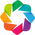

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Path.I     :Path   [Longitude,Latitude]
   .Path.II    :Path   [Longitude,Latitude]
   .Path.III   :Path   [Longitude,Latitude]
   .Points.I   :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.II  :Points   [Longitude,Latitude]   (triangle_angle)
   .Points.III :Points   [Longitude,Latitude]   (triangle_angle)

In [97]:
import holoviews as hv
import movingpandas as mpd
traj_collection = mpd.TrajectoryCollection(prova_gdf, 'node_sn', t='timestamp', x='GPS_lon', y='GPS_lat')
hv.extension('bokeh')
hvplot_defaults = {'tiles':'OSM', 'frame_height':550, 'frame_width':550, 'line_width':7.0}
traj_collection.hvplot(**hvplot_defaults)

In [98]:
from App_function_file import geo_df_to_timestamped_geojson
import json
import os

# key è la tupla es. (3, 0, 'Samsung', 'Gerbole', datetime.datetime(2022, 4, 5, 23, 33, 49))
# value è il gdf della traccia completa percorsa dalla key
for key, value in paths_gfd_dict.items():
    truck_id_path_geojson = geo_df_to_timestamped_geojson(value) # il geodataframe va passato! da quel dict
    timestamped_geojson_name = 'truck_id_' + str(key[0]) + '_serial_' + str(key[1]) + '_from_' + key[2] + '_to_' + key[3]  + '.geojson'

    with open(os.getcwd() + '/Data/Geojson_paths/' + timestamped_geojson_name, 'w') as outfile:
        json.dump(truck_id_path_geojson, outfile, indent=2)

